In [70]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['Churn_Modelling.csv']


# 1). Exploratory Work

## 1a). Plot Distributions of Numerical Variables
I define a custom function to filter a dataframe by a certain data type. That function is defined as filter_by_dataframe. Next I use the filter and plot the distributions of int and float vairables using pandas in-built distibution function dist()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


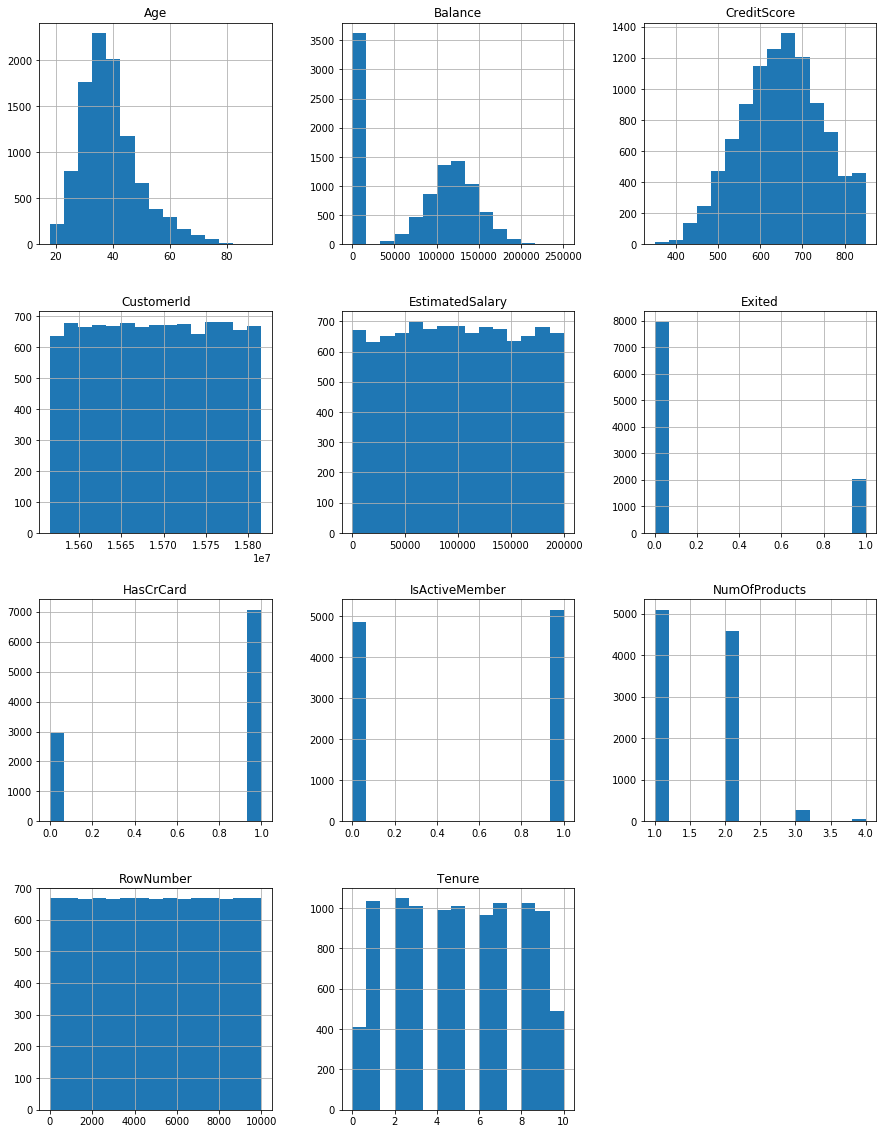

In [29]:
churn = pd.read_csv('../input/Churn_Modelling.csv')

def filter_by_dtype(dataframe, data_type):
    """filter a dataframe by columns with a certain data_type"""
    col_names = dataframe.dtypes[dataframe.dtypes == data_type].index
    return dataframe[col_names]

churn_numerical = pd.concat([filter_by_dtype(churn, int), filter_by_dtype(churn, float)], axis=1)

### Plot Distibutions ###
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
churn_numerical.hist(ax = ax, bins = 15)
plt.show()

**'Age'**, **'CreditScore'**, and **'Balance'** seem to follow nearly normal distribution. **'Balance'** has a large skew at a low balance. This will throw off averages or medians if calculated using this field. 

The other fields are mostlty uniform in distribution. **'Exited'** and **'NumOfProducts'** are different thought, they look like decaying exponential functions.

## 1b). Value Counts by Column
The following cell prints the unique value counts for each categorical column in the dataset. I use a custom function print_column_counts to find these percentages

In [68]:
def print_column_counts(dataframe, list_of_columns):
    """print the percentages of all the unique values in a column"""
    df_len = len(dataframe)
    for name in list_of_columns:
        counts = dataframe[name].value_counts() / df_len
        percents = list(counts); values = list(counts.index)
        values_and_percents = list(zip(values, percents))
        [print(name + ' value ' + str(value) + ' represents ' + str(round(percent * 100, 4)) + '% percent of the field \n') for value, percent in values_and_percents]
        
print_column_counts(churn, ['Exited','HasCrCard','Gender', 'Geography','IsActiveMember','NumOfProducts'])

Exited value 0 represents 79.63% percent of the field 

Exited value 1 represents 20.37% percent of the field 

HasCrCard value 1 represents 70.55% percent of the field 

HasCrCard value 0 represents 29.45% percent of the field 

Gender value Male represents 54.57% percent of the field 

Gender value Female represents 45.43% percent of the field 

Geography value France represents 50.14% percent of the field 

Geography value Germany represents 25.09% percent of the field 

Geography value Spain represents 24.77% percent of the field 

IsActiveMember value 1 represents 51.51% percent of the field 

IsActiveMember value 0 represents 48.49% percent of the field 

NumOfProducts value 1 represents 50.84% percent of the field 

NumOfProducts value 2 represents 45.9% percent of the field 

NumOfProducts value 3 represents 2.66% percent of the field 

NumOfProducts value 4 represents 0.6% percent of the field 



Here we see the field we want to use to train our predictive model **'Exited'** is imbalanced, with almost 80% of our data containing individuals that did not churn (0). 

We also notice other categories are disproportionate. For example, within the **'Gender'** field over half of the data are males (55%) and roughly half of the **'Geography'** field is represented by France with Spain and Germany representing the other half. These percertages will be helpful to keep in mind as we move forward

## 1c). Plot Correlations
Now I'm going to check correlations to see which features most strongly correlate with **'Exited'**. I also want to check if any of the  have any co-linearity or if there are any other interesting correlations in the dataset.

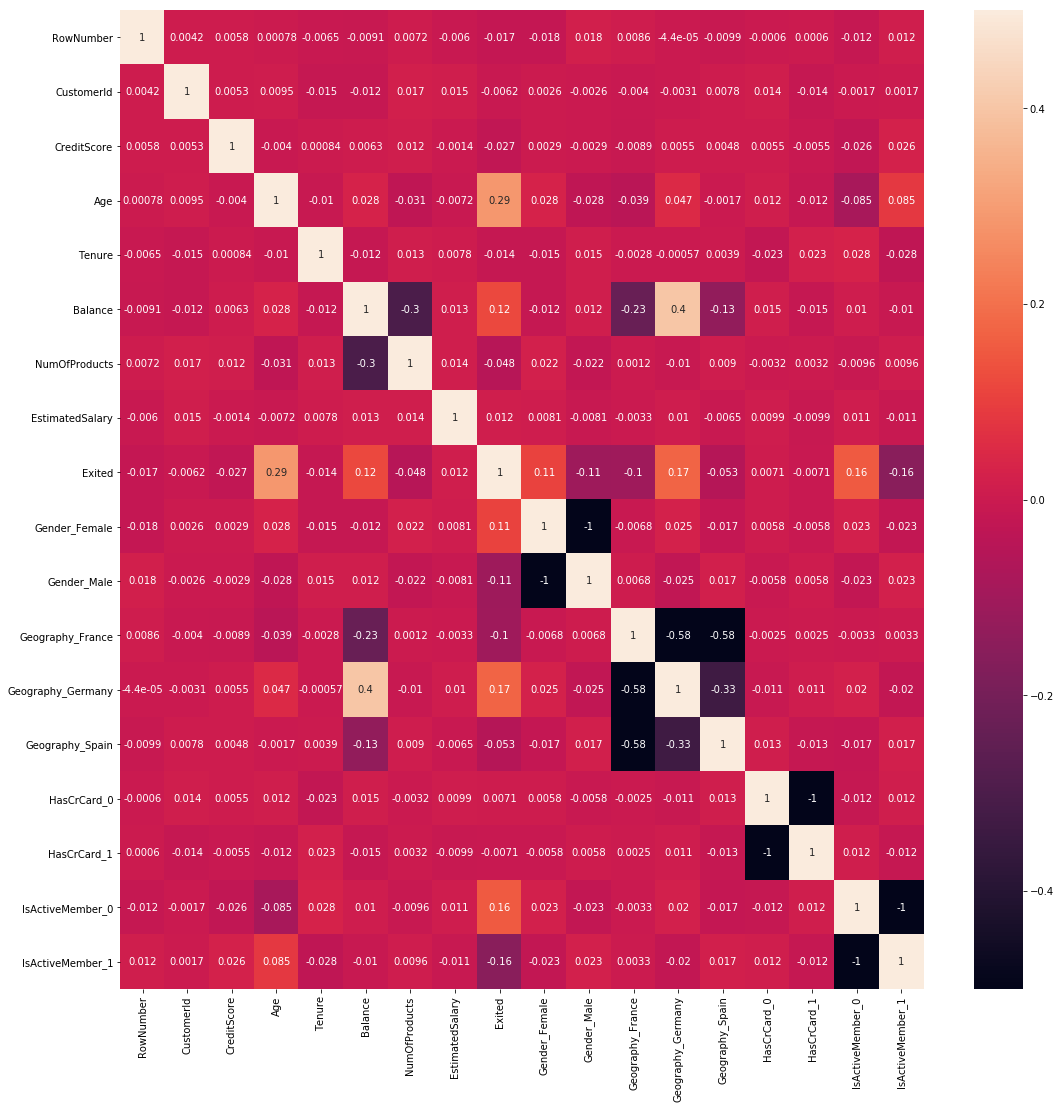

In [86]:
fig = plt.figure(figsize = (18,18)); ax = fig.gca()
one_hot_churn = pd.get_dummies(churn, columns = ['Gender', 'Geography', 'HasCrCard', 'IsActiveMember'])
sns.heatmap(one_hot_churn.corr(), annot = True, vmin= -0.5, vmax = 0.5, ax=ax)

Here we see that **'Age', 'Balance', 'IsActiveMember'**, **'Gender'** and **'NumOfProducts'** are most correlated with **'Exited'** (all still under +/- 0.3 so they are *light* correlations). 

An interesting correlational group is between the country locations **'Geography'** and **'Balance'**. Germany is positively correlated with **'Balance'**, while Spain and France are negatively correlated with **'Balance'**. Meaning in this dataset one is more likely to have a higher balance if they live in Germany than if they live in France or Spain. 

Also worth noting is that the negative correlation between **'Balance' ** and **'NumOfProducts'**. This is a weak negative correlation coming in at -0.3, but it shows that the more products one has, generally, the more likely they are to have a lower balance. 

There aren't many stong correlations in this dataset (outside of one hot groups) so we can conclude that there's no colinearity.

# 2). Train a 'Dumb' Model as a Baseline

A dumb model could turn out to preform quite well. What makes it 'dumb' is that I'll use a simple classification algorithm, off-the-shelf, with no engineered features or feature scaling. I will use this algorithm to rate future algorithms against.

In [88]:
one_hot_churn.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'EstimatedSalary', 'Exited',
       'Gender_Female', 'Gender_Male', 'Geography_France', 'Geography_Germany',
       'Geography_Spain', 'HasCrCard_0', 'HasCrCard_1', 'IsActiveMember_0',
       'IsActiveMember_1'],
      dtype='object')

## 2a). Train-Test Split 

In [110]:
np.random.seed(123)

keep_columns = ['CreditScore', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'EstimatedSalary',
       'Gender_Female', 'Gender_Male', 'Geography_France', 'Geography_Germany',
       'Geography_Spain', 'HasCrCard_0', 'HasCrCard_1', 'IsActiveMember_0',
       'IsActiveMember_1']

label = ['Exited']

shuffled_churn = one_hot_churn.sample(frac=1).reset_index(drop=True)
churn_train = shuffled_churn[keep_columns]
churn_label = shuffled_churn[label]
split_num = int(len(shuffled_churn) * 0.8)

train_x = churn_train.iloc[:split_num,:]
train_y = churn_label[:split_num]
test_x = churn_train.iloc[split_num:,:]
test_y = churn_label[split_num:]

In [116]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_x, train_y)
pred_y = neigh.predict(test_x)
print(neigh.score(train_x, train_y))
conf = confusion_matrix(test_y, pred_y)
conf

0.843125


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


array([[1400,  177],
       [ 379,   44]])

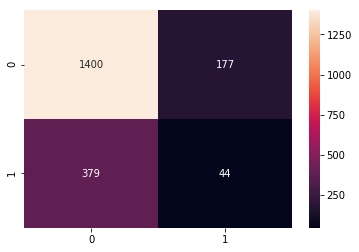

In [118]:
sns.heatmap(conf, annot = True, fmt='g')

At 84% the model has learned *something*, but it's not as good as it may sound. For instance, If the model were to just guess '0' everytime, it'd end up with 80% accuracy (remember the percentages from section 1b?) because '0's make up 80% of the labeled values. 

This is a good first pass though. 

### Thank you for reading, More to come!